# Predicting crops based on the soil metrics

![img/farmer_in_a_field.jpg](img/farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  


**Disclaimer**: This project was completed originally as part of the Data Camp's Data Science Professional track. Ever since, it's been improved by:
- exploring features' distribution,
- testing for multicollinearity using VIF,
- perfoming feature selection, 
- training alternative machine learning models (such as Random Forest and Neural Network) to the Logistic Regression model used in the original project
- performing cross-validation to tune the hyperparameters of the models and providing an interpretation of the results

### 1. Data Collection and Exploration

- Exploring the dataset to understand its structure, check for missing values.
- Visualizing the distribution of each soil metric (N, P, K, pH) across different crop types.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.metrics import f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Load the dataset
crops = pd.read_csv("dataset/soil_measures.csv")

In [2]:
crops.head() #visualizing the first 5 rows

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [3]:
crops.shape

(2200, 5)

In [4]:
crops.isnull().sum() #checking for missing values

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

In [5]:
crops.dtypes #checking the data type of each column

N         int64
P         int64
K         int64
ph      float64
crop     object
dtype: object

In [6]:
crops['crop'].value_counts()

crop
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

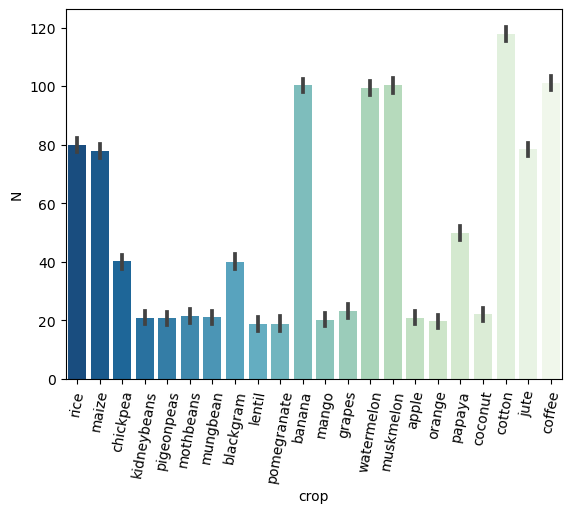

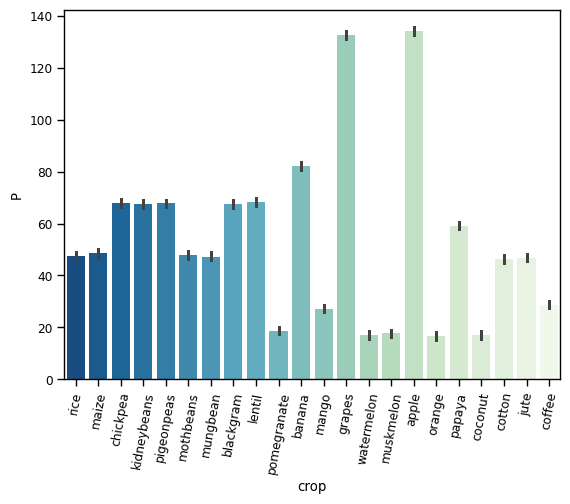

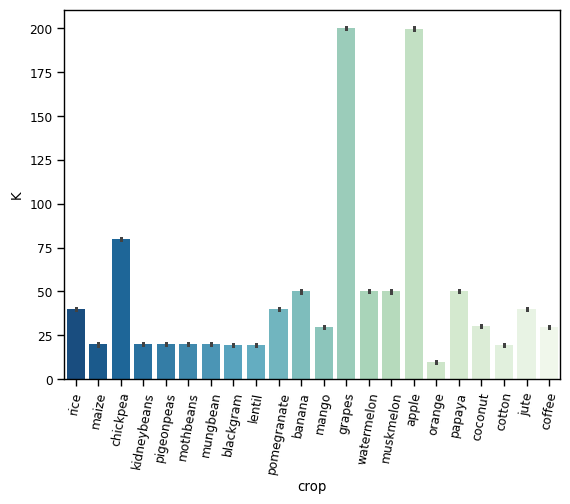

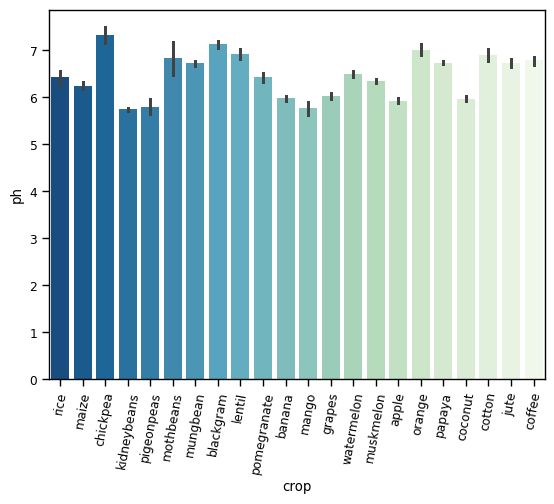

In [2]:
# Visualizing the distribution of each soil metric (N, P, K, pH) across different crop types.

cols=crops.columns.to_list()[:-1]

def plot_crops_soil(col):
    sns.barplot(y= col, x = "crop", data = crops, palette=("GnBu_r"))
    plt.xticks(rotation=80)
    sns.set_context('paper')
    plt.show()

for col in cols:
    plot_crops_soil(col)

observation

### 2. Data Processing (Train, Test split)

In [2]:
X=crops.drop('crop', axis=1)
y=crops[['crop']]
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=22)

### 3. Feature Selection and Engineering

Assessing the importance of each soil metric in predicting crop types:

- *Feature importance based on mean decrease in impurity* : feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.  This is not recommended for high cardinality features
        
- *Feature importance based on feature permutation*: permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

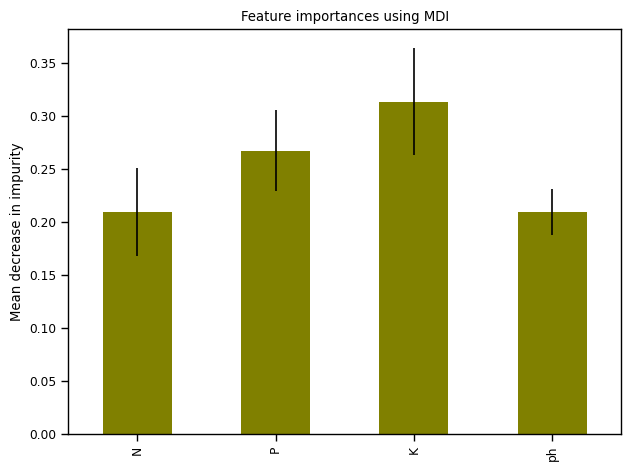

In [9]:
# Assess feature importance using Random Forest
forest=RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, color='olive')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


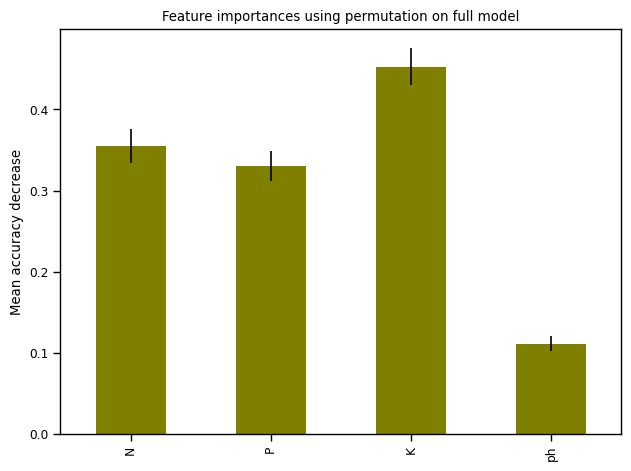

In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color='olive')
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Observations: All the features seems to be important based on the above metrics.

### 4. Testing for multicollinearity
- using the coefficients correlation
- VIF (variance inflation factor)

In [11]:
# Correlation matrix

X_train.corr()

,N,P,K,ph
N,1.000000,-0.237410,-0.144130,0.088276
P,-0.237410,1.000000,0.736475,-0.139021
K,-0.144130,0.736475,1.000000,-0.169690
ph,0.088276,-0.139021,-0.169690,1.000000


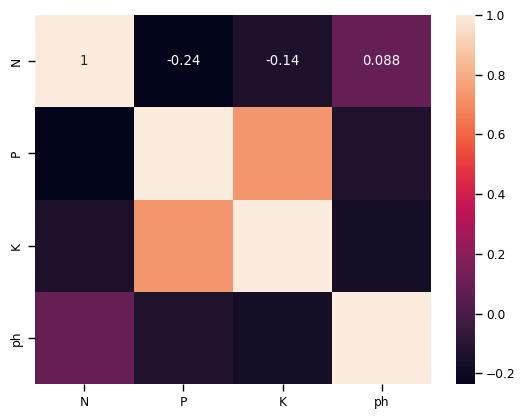

In [12]:
sns.heatmap(X_train.corr(), annot=True)
plt.show()

In [21]:
# Add column of constants for VIF function
X_const = add_constant(X_train)

# Compute the variance inflation factor (VIF) for each feature
vif = pd.Series([variance_inflation_factor(X_const.values, i) for i in range(X_train.shape[1])], 
                index = X_train.columns)
print("Variance Inflation Factors:")
print(vif)

Variance Inflation Factors:
N     79.509275
P      1.066221
K      2.272837
ph     2.213762
dtype: float64


**Observations**: `N` has a VIF score higher than 10 which indicates the presence of multicolinearity with other predictors. Therefore, it will be removed from the predictor list to prevent unreliable estimates.

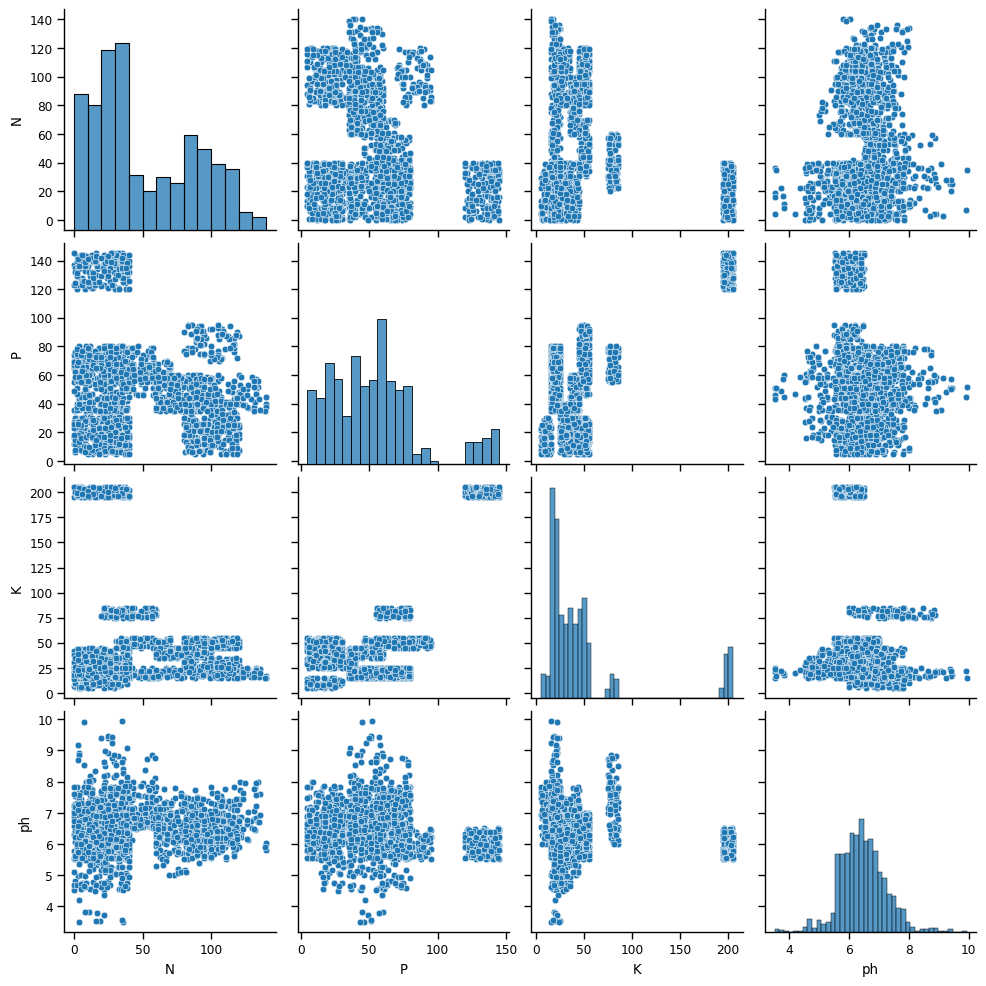

In [22]:
import seaborn as sns
sns.pairplot(X_train) 

In [3]:
features_selected=['P', 'K', 'ph']

### 5. Model Selection and Training:
- Exploring Logistic Regression, Random Forest, Neural Network
- Training the model using the training data.
- Tuning hyperparameters using GridSearchCV.

#### a. Logistic Regression

In [40]:
# fitting a multiclass base model
log_reg=LogisticRegression(max_iter=2000, multi_class='multinomial')
log_reg.fit(X_train[features_selected], y_train)
y_pred = log_reg.predict(X_test[features_selected])
model_performance = f1_score(y_test, y_pred, average='weighted')
model_performance

0.5036659111494324

In [29]:
params = {'C': np.logspace(-2, 0, 2),
              'penalty': ['none', 'l2', 'l1', 'elasticnet'],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

grid_search = GridSearchCV(log_reg, params, cv=5, verbose=2, scoring='f1_weighted')
log_reg_cv = grid_search.fit(X_train[features_selected], y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time= 1.9min
[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time=  55.4s
[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time= 1.6min
[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time= 2.2min
[CV] END .............C=0.01, penalty=none, solver=newton-cg; total time=  54.7s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   1.2s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   1.2s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   1.3s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   1.3s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   1.1s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.9s
[CV] END ...................C=0.01, penalty=non

In [30]:
print(f'Best estimator: {log_reg_cv.best_estimator_}')
print(f'Best paramter combination: {log_reg_cv.best_params_}')
print(f'Best score: {log_reg_cv.best_score_}')

Best estimator: LogisticRegression(max_iter=2000, multi_class='multinomial', solver='newton-cg')
Best paramter combination: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.5705004500285327


#### b. Random Forest

In [33]:
rf_model=RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train[features_selected], y_train)

y_pred_rf = rf_model.predict(X_test[features_selected])
f1_score(y_test, y_pred_rf, average='weighted')

0.6285264993409722

In [34]:
param_rf = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [2*n for n in range(1,5)],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

grid_search_rf = GridSearchCV(rf_model, param_rf, cv=10, verbose=1, scoring='f1_weighted')
forest_cv = grid_search_rf.fit(X_train[features_selected], y_train)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


In [37]:
print("Tuned hpyerparameters (best parameters):", forest_cv.best_params_)
print("Train F1score:", forest_cv.best_score_)
print("Test accuracy:", forest_cv.best_estimator_.score(X_test[features_selected], y_test))

Tuned hpyerparameters (best parameters): {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}
Train F1score: 0.6797677153398072
Test accuracy: 0.6659090909090909


#### c. Neural network

In [53]:
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

num_classes = y_train.nunique()



# create model
tf_model = tf.keras.Sequential([
                            tf.keras.layers.Dense(64, activation='relu', input_dim=X_train[features_selected].shape[1]),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Dense(num_classes[0], activation='softmax')
                                ])

tf_model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tfa.metrics.F1Score(num_classes=num_classes[0]))
        metrics=['accuracy'])

History=tf_model.fit(X_train[features_selected], y_train_encoded, epochs=100, validation_data=(X_test[features_selected], y_test_encoded), shuffle=True)

Epoch 1/100


55/55 [==============================] - 1s 6ms/step - loss: 4.0846 - accuracy: 0.1153 - val_loss: 2.3232 - val_accuracy: 0.2000
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 2.0399 - accuracy: 0.2597 - val_loss: 1.9088 - val_accuracy: 0.3409
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 1.7684 - accuracy: 0.3290 - val_loss: 1.6725 - val_accuracy: 0.3614
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 1.6613 - accuracy: 0.3727 - val_loss: 1.5684 - val_accuracy: 0.4159
Epoch 5/100
55/55 [==============================] - 0s 2ms/step - loss: 1.5182 - accuracy: 0.4006 - val_loss: 1.5404 - val_accuracy: 0.3659
Epoch 6/100
55/55 [==============================] - 0s 3ms/step - loss: 1.4132 - accuracy: 0.4295 - val_loss: 1.4800 - val_accuracy: 0.3932
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 1.3498 - accuracy: 0.4449 - val_loss: 1.3828 - val_accuracy: 0.3841
Epoch 8/100
55/55 [======

In [56]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=History.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=History.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=History.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=History.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Loss/Accuracy of Neural Network Model"
)

fig.update_xaxes(title_text="Epoch")

fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()


In [57]:
#finetuning the model for learning rate
tf.random.set_seed(123)

tf_model_lr = tf.keras.Sequential([
                            tf.keras.layers.Dense(64, activation='relu', input_dim=X_train[features_selected].shape[1]),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Dense(num_classes[0], activation='softmax')
                                ])
tf_model_lr.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=tfa.metrics.F1Score(num_classes=num_classes[0]))
        metrics=['accuracy'])

scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
history_lr=tf_model_lr.fit(X_train[features_selected], y_train_encoded, epochs=100, validation_data=(X_test[features_selected], y_test_encoded), shuffle=True, callbacks=[scheduler])

Epoch 1/100
55/55 [==============================] - 1s 6ms/step - loss: 9.4567 - accuracy: 0.0886 - val_loss: 7.2151 - val_accuracy: 0.0750 - lr: 1.0000e-04
Epoch 2/100
55/55 [==============================] - 0s 3ms/step - loss: 5.5507 - accuracy: 0.1097 - val_loss: 4.4360 - val_accuracy: 0.0864 - lr: 1.1220e-04
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 3.6348 - accuracy: 0.1631 - val_loss: 3.1620 - val_accuracy: 0.1614 - lr: 1.2589e-04
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 2.8508 - accuracy: 0.2102 - val_loss: 2.6398 - val_accuracy: 0.1773 - lr: 1.4125e-04
Epoch 5/100
55/55 [==============================] - 0s 2ms/step - loss: 2.4575 - accuracy: 0.2205 - val_loss: 2.3392 - val_accuracy: 0.2227 - lr: 1.5849e-04
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 2.2091 - accuracy: 0.2517 - val_loss: 2.1518 - val_accuracy: 0.2409 - lr: 1.7783e-04
Epoch 7/100
55/55 [==============================] -

In [85]:
#best learning rate is where the loss has descrease enough but hasn't flattened out yet = 10^-4<x<10^-3

#lrs = 1e-4 * (10 ** (np.arange(100)/20))
lrs = 1e-4 * (10 ** (tf.range(100)/20))

fig = go.Figure()

fig.add_trace(go.Scatter(x=lrs, y=history_lr.history['loss'], mode='lines', name='Loss'))

# Highlight the range of interest
highlighted_lrs = lrs[(lrs > 10**(-4)) & (lrs < 10**(-3))]
highlighted_losses = [history_lr.history['loss'][np.argmin(np.abs(lrs - lr))] for lr in highlighted_lrs]
fig.add_trace(go.Scatter(x=highlighted_lrs, y=highlighted_losses, mode='markers', name='Best LR Range', marker=dict(size=10)))

# Customize the layout
fig.update_layout(
    title="Learning Rate vs. Loss",
    xaxis_title="Learning Rate",
    yaxis_title="Loss",
    xaxis_type="log",
    width=1500,
    height=600
)

# Show the plot
fig.show()

In [84]:
[x for x in lrs if 10**(-4) < x < 10**(-3)]

[<tf.Tensor: shape=(), dtype=float64, numpy=0.00011220184543019634>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00012589254117941674>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00014125375446227543>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00015848931924611136>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0001778279410038923>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00019952623149688796>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00022387211385683394>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.000251188643150958>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0002818382931264454>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00031622776601683794>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00035481338923357554>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.00039810717055349724>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0004466835921509632>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0005011872336272722>,
 <tf.Tensor: shape=(), dtype=float64, nu

### 6. Model Evaluation
Comparing the performance of the various models used.
Using confusion matrices to understand classification errors.